In [2]:
import pandas as pd
# Specify the path to your Parquet file
transactions_parquet_file_path = 'data/optimized_transactions_df.parquet'
rent_parquet_file_path = 'data/optimized_rent_df.parquet'

# Load the Parquet file into a pandas DataFrame
transactions_df = pd.read_parquet(transactions_parquet_file_path, engine='pyarrow')
# Load the Parquet file into a pandas DataFrame
rent_df = pd.read_parquet(rent_parquet_file_path, engine='pyarrow')


# valuations_df = pd.read_csv("../data/valuations-2024-11-23.csv", on_bad_lines='skip')
# projects_df = pd.read_csv("../data/projects-2024-11-23 (1).csv", on_bad_lines='skip')
# lands_df = pd.read_csv("../data/lands-2024-11-23.csv", on_bad_lines='skip',low_memory=False)
# developers_df = pd.read_csv("../data/developers-2024-11-23.csv", on_bad_lines='skip')
# brokers_df = pd.read_csv("../data/brokers-2024-11-23.csv", on_bad_lines='skip')


In [3]:
print("Transactions DataFrame Info:")
transactions_df.info()
print("\nMissing Values in Transactions DataFrame:")
print(transactions_df.isnull().sum())
# Identify object type columns (usually categorical)
categorical_columns = transactions_df.select_dtypes(include=['category']).columns.tolist()
print("\nCategorical Columns in Transactions DataFrame:")
print(categorical_columns)
for column in categorical_columns:
    unique_values = transactions_df[column].unique()
    print(f"\nUnique values in '{column}' ({len(unique_values)}):")
    print(unique_values)
    
print("\nMissing Values in Transactions DataFrame:")
print(transactions_df.isnull().sum())
transactions_df.describe()

Transactions DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206443 entries, 0 to 206442
Data columns (total 22 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   TRANSACTION_NUMBER   206443 non-null  object        
 1   INSTANCE_DATE        206443 non-null  datetime64[ns]
 2   GROUP_EN             206443 non-null  category      
 3   PROCEDURE_EN         206443 non-null  category      
 4   IS_OFFPLAN_EN        206443 non-null  category      
 5   IS_FREE_HOLD_EN      206443 non-null  category      
 6   USAGE_EN             206443 non-null  category      
 7   AREA_EN              206443 non-null  category      
 8   PROP_TYPE_EN         206443 non-null  category      
 9   PROP_SB_TYPE_EN      204652 non-null  category      
 10  TRANS_VALUE          206443 non-null  float32       
 11  PROCEDURE_AREA       205613 non-null  float32       
 12  ACTUAL_AREA          206443 non-null  float

,INSTANCE_DATE,TRANS_VALUE,PROCEDURE_AREA,ACTUAL_AREA,TOTAL_BUYER,TOTAL_SELLER
count,206443,2.064430e+05,2.056130e+05,2.064430e+05,206443.000000,206443.000000
mean,2024-06-25 08:41:30.457898496,3.255351e+06,6.925069e+02,6.863133e+02,0.929404,0.850244
min,2024-01-01 00:00:00,1.008900e+02,1.000000e-02,5.170000e+00,0.000000,0.000000
25%,2024-04-07 00:00:00,8.500000e+05,6.519000e+01,6.584500e+01,1.000000,1.000000
50%,2024-07-02 00:00:00,1.494921e+06,9.457000e+01,9.530000e+01,1.000000,1.000000
75%,2024-09-17 00:00:00,2.703888e+06,1.631200e+02,1.640300e+02,1.000000,1.000000
max,2024-11-22 00:00:00,4.248836e+09,2.000081e+07,2.000081e+07,21.000000,48.000000
std,NaN,2.399319e+07,7.414626e+04,7.390269e+04,0.635223,0.708849


In [34]:
import pandas as pd
import numpy as np
import gc

# Define enhanced downcasting functions
def downcast_integer(col):
    """
    Downcast integer columns to the smallest possible subtype without data loss.
    """
    col_min = col.min()
    col_max = col.max()
    
    if col_min >= 0:
        if col_max < 256:
            return col.astype('uint8')
        elif col_max < 65536:
            return col.astype('uint16')
        elif col_max < 4294967296:
            return col.astype('uint32')
        else:
            return col  # No downcast possible
    else:
        if col_min >= -128 and col_max <= 127:
            return col.astype('int8')
        elif col_min >= -32768 and col_max <= 32767:
            return col.astype('int16')
        elif col_min >= -2147483648 and col_max <= 2147483647:
            return col.astype('int32')
        else:
            return col  # No downcast possible

def downcast_float(col):
    """
    Downcast float columns to float32 or float16 if possible without significant loss.
    Only downcast to float16 if all values are within the float16 range.
    """
    float16_min = -65504.0
    float16_max = 65504.0
    
    col_min = col.min()
    col_max = col.max()
    
    # Check if all values fit within float16 range
    if col_min >= float16_min and col_max <= float16_max:
        # Attempt to downcast to float16
        col_downcasted = col.astype('float16')
        # Verify that downcasting didn't introduce significant errors
        if np.allclose(col, col_downcasted, equal_nan=True, rtol=1e-3, atol=1e-3):
            return col_downcasted
    # If not, downcast to float32
    return col.astype('float32')

# Define the optimization function for transactions_df
def optimize_transactions_dataframe(df):
    """
    Optimize the Transactions DataFrame by downcasting numerical columns and converting suitable object columns to categorical.
    """
    # Display initial memory usage
    start_mem = df.memory_usage(deep=True).sum() / 1024**2
    print(f"Initial memory usage: {start_mem:.2f} MB")
    
    # ----------------------------
    # 1. Convert Date Columns to Datetime
    # ----------------------------
    date_columns = ['INSTANCE_DATE']
    for col in date_columns:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col], errors='coerce').dt.normalize()
            print(f"Converted and normalized '{col}' to datetime.")
    
    # ----------------------------
    # 2. Convert Suitable Object Columns to Categorical
    # ----------------------------
    categorical_columns = [
        'TRANSACTION_NUMBER', 'GROUP_EN', 'PROCEDURE_EN', 'IS_OFFPLAN_EN',
        'IS_FREE_HOLD_EN', 'USAGE_EN', 'AREA_EN', 'PROP_TYPE_EN',
        'PROP_SB_TYPE_EN', 'ROOMS_EN', 'PARKING', 'NEAREST_METRO_EN',
        'NEAREST_MALL_EN', 'NEAREST_LANDMARK_EN', 'MASTER_PROJECT_EN',
        'PROJECT_EN'
    ]
    
    for col in categorical_columns:
        if col in df.columns:
            num_unique = df[col].nunique()
            num_total = len(df[col])
            # Adjusted threshold to 30% to better handle high cardinality
            if num_unique / num_total < 0.3:
                df[col] = df[col].astype('category')
                print(f"Converted '{col}' to 'category' dtype.")
            else:
                print(f"Skipped converting '{col}' to 'category' dtype (cardinality ratio: {num_unique / num_total:.2f}).")
    
    # ----------------------------
    # 3. Downcast Integer Columns
    # ----------------------------
    int_cols = df.select_dtypes(include=['int64', 'int32']).columns.tolist()
    for col in int_cols:
        if col in df.columns:
            original_dtype = df[col].dtype
            df[col] = downcast_integer(df[col])
            print(f"Downcasted '{col}' from {original_dtype} to {df[col].dtype}.")
    
    # ----------------------------
    # 4. Downcast Float Columns
    # ----------------------------
    float_cols = df.select_dtypes(include=['float64', 'float32']).columns.tolist()
    for col in float_cols:
        if col in df.columns:
            original_dtype = df[col].dtype
            df[col] = downcast_float(df[col])
            print(f"Downcasted '{col}' from {original_dtype} to {df[col].dtype}.")
    
    # ----------------------------
    # 5. Handle Specific Columns if Needed
    # ----------------------------
    # Example: 'ANNUAL_AMOUNT' has 20 missing values
    # Already handled by downcasting functions which preserve NaNs
    
    # ----------------------------
    # 6. Convert Remaining Object Columns to Categorical
    # ----------------------------
    remaining_object_cols = df.select_dtypes(include=['object']).columns.tolist()
    for col in remaining_object_cols:
        num_unique = df[col].nunique()
        num_total = len(df[col])
        if num_unique / num_total < 0.3:
            df[col] = df[col].astype('category')
            print(f"Converted '{col}' to 'category' dtype.")
        else:
            print(f"Skipped converting '{col}' to 'category' dtype (cardinality ratio: {num_unique / num_total:.2f}).")
    
    # ----------------------------
    # 7. Remove Unused Categories
    # ----------------------------
    categorical_cols = df.select_dtypes(['category']).columns.tolist()
    for col in categorical_cols:
        df[col] = df[col].cat.remove_unused_categories()
        print(f"Removed unused categories from '{col}'.")
    
    # ----------------------------
    # 8. Reset Index to RangeIndex
    # ----------------------------
    df.reset_index(drop=True, inplace=True)
    print("Reset index to RangeIndex.")
    
    # ----------------------------
    # 9. Display Final Memory Usage
    # ----------------------------
    end_mem = df.memory_usage(deep=True).sum() / 1024**2
    print(f"Final memory usage: {end_mem:.2f} MB")
    print(f"Decreased by {(start_mem - end_mem) / start_mem * 100:.1f}%")
    
    return df

# Assuming your Transactions DataFrame is named 'transactions_df'
# Replace this with your actual DataFrame loading method
# Example:
# transactions_df = pd.read_csv('transactions_data.csv')

# Optimize the Transactions DataFrame
optimized_transactions_df = optimize_transactions_dataframe(transactions_df)

# Save the optimized DataFrame to a Pickle file
optimized_transactions_df.to_pickle('optimized_transactions_df.pkl')
print("Optimized DataFrame saved to 'optimized_transactions_df.pkl'.")

# Additionally, save in Parquet format with compression for better storage efficiency
optimized_transactions_df.to_parquet('optimized_transactions_df.parquet', compression='snappy')
print("Optimized DataFrame also saved to 'optimized_transactions_df.parquet' with Snappy compression.")

# Optionally, save as Feather for faster read/write operations
optimized_transactions_df.to_feather('optimized_transactions_df.feather')
print("Optimized DataFrame also saved to 'optimized_transactions_df.feather'.")

# Invoke garbage collection to free up memory
gc.collect()


Initial memory usage: 195.17 MB
Converted and normalized 'INSTANCE_DATE' to datetime.
Skipped converting 'TRANSACTION_NUMBER' to 'category' dtype (cardinality ratio: 0.97).
Converted 'GROUP_EN' to 'category' dtype.
Converted 'PROCEDURE_EN' to 'category' dtype.
Converted 'IS_OFFPLAN_EN' to 'category' dtype.
Converted 'IS_FREE_HOLD_EN' to 'category' dtype.
Converted 'USAGE_EN' to 'category' dtype.
Converted 'AREA_EN' to 'category' dtype.
Converted 'PROP_TYPE_EN' to 'category' dtype.
Converted 'PROP_SB_TYPE_EN' to 'category' dtype.
Converted 'ROOMS_EN' to 'category' dtype.
Converted 'PARKING' to 'category' dtype.
Converted 'NEAREST_METRO_EN' to 'category' dtype.
Converted 'NEAREST_MALL_EN' to 'category' dtype.
Converted 'NEAREST_LANDMARK_EN' to 'category' dtype.
Converted 'MASTER_PROJECT_EN' to 'category' dtype.
Converted 'PROJECT_EN' to 'category' dtype.
Downcasted 'TOTAL_BUYER' from int64 to uint8.
Downcasted 'TOTAL_SELLER' from int64 to uint8.
Downcasted 'TRANS_VALUE' from float64 to f

19

In [35]:
import pandas as pd
import numpy as np
import gc

# Assuming transactions_df is already loaded and optimized

# Define a helper function to add a new category if it doesn't exist
def add_category_if_missing(df, column, new_category):
    """
    Adds a new category to a categorical column if it doesn't already exist.
    
    Parameters:
        df (pd.DataFrame): The DataFrame containing the column.
        column (str): The column name.
        new_category (str): The new category to add.
    
    Returns:
        None
    """
    if df[column].dtype.name == 'category':
        if new_category not in df[column].cat.categories:
            df[column] = df[column].cat.add_categories([new_category])
            print(f"Added new category '{new_category}' to '{column}'.")
    else:
        # If the column is not categorical, no action is needed
        pass

# 1. Drop 'MASTER_PROJECT_EN' due to high missingness
if 'MASTER_PROJECT_EN' in transactions_df.columns:
    transactions_df = transactions_df.drop(columns=['MASTER_PROJECT_EN'])
    print("Dropped 'MASTER_PROJECT_EN' due to high missingness.")

# 2. Handle 'NEAREST_METRO_EN', 'NEAREST_MALL_EN', 'NEAREST_LANDMARK_EN'
for col in ['NEAREST_METRO_EN', 'NEAREST_MALL_EN', 'NEAREST_LANDMARK_EN']:
    if col in transactions_df.columns:
        add_category_if_missing(transactions_df, col, 'Unknown')
        transactions_df[col] = transactions_df[col].fillna('Unknown')
        print(f"Filled missing values in '{col}' with 'Unknown'.")

# 3. Handle 'ROOMS_EN'
# Create 'Not_Applicable' category
if 'ROOMS_EN' in transactions_df.columns:
    add_category_if_missing(transactions_df, 'ROOMS_EN', 'Not_Applicable')
    transactions_df['ROOMS_EN'] = transactions_df['ROOMS_EN'].fillna('Not_Applicable')
    print("Filled missing values in 'ROOMS_EN' with 'Not_Applicable'.")

# 4. Handle 'PARKING' Conditionally Based on Property Type
if 'PARKING' in transactions_df.columns and 'PROP_TYPE_EN' in transactions_df.columns:
    # Define the value indicating a villa in 'PROP_TYPE_EN'
    villa_property_type = 'Villa'
    
    # Define the imputation values
    parking_for_villa = 'Available'
    parking_for_others = 'No_Parking'
    
    # Add new categories if necessary
    add_category_if_missing(transactions_df, 'PARKING', parking_for_villa)
    add_category_if_missing(transactions_df, 'PARKING', parking_for_others)
    
    # Conditional imputation
    # Impute 'PARKING' for Villas
    villa_mask = transactions_df['PROP_TYPE_EN'].str.strip().str.lower() == villa_property_type.lower()
    missing_parking_villa = transactions_df['PARKING'].isnull() & villa_mask
    transactions_df.loc[missing_parking_villa, 'PARKING'] = parking_for_villa
    print(f"Filled missing 'PARKING' for Villas with '{parking_for_villa}'.")
    
    # Impute 'PARKING' for Non-Villas
    non_villa_mask = transactions_df['PROP_TYPE_EN'].str.strip().str.lower() != villa_property_type.lower()
    missing_parking_non_villa = transactions_df['PARKING'].isnull() & non_villa_mask
    transactions_df.loc[missing_parking_non_villa, 'PARKING'] = parking_for_others
    print(f"Filled missing 'PARKING' for Non-Villas with '{parking_for_others}'.")

# 5. Handle 'PROP_SB_TYPE_EN'
if 'PROP_SB_TYPE_EN' in transactions_df.columns:
    add_category_if_missing(transactions_df, 'PROP_SB_TYPE_EN', 'Not_Known')
    transactions_df['PROP_SB_TYPE_EN'] = transactions_df['PROP_SB_TYPE_EN'].fillna('Not_Known')
    print("Filled missing values in 'PROP_SB_TYPE_EN' with 'Not_Known'.")

# 6. Handle 'PROCEDURE_AREA'
if 'PROCEDURE_AREA' in transactions_df.columns:
    # Assuming 'PROCEDURE_AREA' is numerical, but based on previous code it might be categorical
    # If it's categorical:
    if transactions_df['PROCEDURE_AREA'].dtype.name == 'category':
        add_category_if_missing(transactions_df, 'PROCEDURE_AREA', 'Not_Known')
        transactions_df['PROCEDURE_AREA'] = transactions_df['PROCEDURE_AREA'].fillna('Not_Known')
        print("Filled missing values in 'PROCEDURE_AREA' with 'Not_Known'.")
    else:
        # If it's numerical, decide on appropriate imputation, e.g., median
        transactions_df['PROCEDURE_AREA'] = transactions_df['PROCEDURE_AREA'].fillna(transactions_df['PROCEDURE_AREA'].median())
        print("Filled missing values in 'PROCEDURE_AREA' with median value.")

# 7. Assign 'Unknown' to missing 'PROJECT_EN' values
if 'PROJECT_EN' in transactions_df.columns:
    add_category_if_missing(transactions_df, 'PROJECT_EN', 'Unknown')
    transactions_df['PROJECT_EN'] = transactions_df['PROJECT_EN'].fillna('Unknown')
    print("Filled missing values in 'PROJECT_EN' with 'Unknown'.")

# 8. Verify the imputations
print("\nMissing Values After Imputation:")
print(transactions_df[['PROJECT_EN', 'PARKING']].isnull().sum())


Dropped 'MASTER_PROJECT_EN' due to high missingness.
Added new category 'Unknown' to 'NEAREST_METRO_EN'.
Filled missing values in 'NEAREST_METRO_EN' with 'Unknown'.
Added new category 'Unknown' to 'NEAREST_MALL_EN'.
Filled missing values in 'NEAREST_MALL_EN' with 'Unknown'.
Added new category 'Unknown' to 'NEAREST_LANDMARK_EN'.
Filled missing values in 'NEAREST_LANDMARK_EN' with 'Unknown'.
Added new category 'Not_Applicable' to 'ROOMS_EN'.
Filled missing values in 'ROOMS_EN' with 'Not_Applicable'.
Added new category 'Available' to 'PARKING'.
Added new category 'No_Parking' to 'PARKING'.
Filled missing 'PARKING' for Villas with 'Available'.
Filled missing 'PARKING' for Non-Villas with 'No_Parking'.
Added new category 'Not_Known' to 'PROP_SB_TYPE_EN'.
Filled missing values in 'PROP_SB_TYPE_EN' with 'Not_Known'.
Filled missing values in 'PROCEDURE_AREA' with median value.
Added new category 'Unknown' to 'PROJECT_EN'.
Filled missing values in 'PROJECT_EN' with 'Unknown'.

Missing Values Af

In [ ]:
print("rent_df DataFrame Info:")
rent_df.info()
print("\nMissing Values in rent_df DataFrame:")
print(rent_df.isnull().sum())
# Identify object type columns (usually categorical)
categorical_columns = rent_df.select_dtypes(include=['category']).columns.tolist()
print("\nCategorical Columns in rent_df DataFrame:")
print(categorical_columns)
for column in categorical_columns:
    unique_values = rent_df[column].unique()
    print(f"\nUnique values in '{column}' ({len(unique_values)}):")
    print(unique_values)
    
print("\nMissing Values in rent_df DataFrame:")
print(rent_df.isnull().sum())
rent_df.describe()

rent_df DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 949225 entries, 0 to 949224
Data columns (total 20 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   REGISTRATION_DATE    949225 non-null  object 
 1   START_DATE           949225 non-null  object 
 2   END_DATE             949225 non-null  object 
 3   VERSION_EN           949225 non-null  object 
 4   AREA_EN              949225 non-null  object 
 5   CONTRACT_AMOUNT      949225 non-null  float64
 6   ANNUAL_AMOUNT        949205 non-null  float64
 7   IS_FREE_HOLD_EN      949225 non-null  object 
 8   ACTUAL_AREA          949225 non-null  float64
 9   PROP_TYPE_EN         949225 non-null  object 
 10  PROP_SUB_TYPE_EN     945808 non-null  object 
 11  ROOMS                32634 non-null   float64
 12  USAGE_EN             945535 non-null  object 
 13  NEAREST_METRO_EN     807264 non-null  object 
 14  NEAREST_MALL_EN      794921 non-null  object

,CONTRACT_AMOUNT,ANNUAL_AMOUNT,ACTUAL_AREA,ROOMS,PARKING,TOTAL_PROPERTIES
count,9.492250e+05,9.492050e+05,9.492250e+05,32634.000000,19926.000000,949225.000000
mean,5.411753e+05,3.295310e+05,1.640627e+03,3.327818,1.079795,10.803438
std,4.281370e+06,1.595449e+06,6.214154e+05,0.873780,5.155115,44.571775
min,-7.300000e+04,-7.300000e+04,0.000000e+00,1.000000,0.000000,1.000000
25%,3.900000e+04,4.000000e+04,3.000000e+01,3.000000,0.000000,1.000000
50%,6.400000e+04,6.500000e+04,6.832000e+01,3.000000,1.000000,1.000000
75%,1.310000e+05,1.312500e+05,1.123600e+02,4.000000,2.000000,1.000000
max,4.410800e+08,1.150000e+08,3.730996e+08,10.000000,385.000000,636.000000


In [31]:
import pandas as pd
import numpy as np
import gc

# Define enhanced downcasting functions
def downcast_integer(col):
    """
    Downcast integer columns to the smallest possible subtype without data loss.
    """
    col_min = col.min()
    col_max = col.max()
    
    if col_min >= 0:
        if col_max < 256:
            return col.astype('uint8')
        elif col_max < 65536:
            return col.astype('uint16')
        elif col_max < 4294967296:
            return col.astype('uint32')
        else:
            return col  # No downcast possible
    else:
        if col_min >= -128 and col_max <= 127:
            return col.astype('int8')
        elif col_min >= -32768 and col_max <= 32767:
            return col.astype('int16')
        elif col_min >= -2147483648 and col_max <= 2147483647:
            return col.astype('int32')
        else:
            return col  # No downcast possible

def downcast_float(col):
    """
    Downcast float columns to float32 or float16 if possible without significant loss.
    Only downcast to float16 if all values are within the float16 range.
    """
    float16_min = -65504.0
    float16_max = 65504.0
    
    col_min = col.min()
    col_max = col.max()
    
    # Check if all values fit within float16 range
    if col_min >= float16_min and col_max <= float16_max:
        # Attempt to downcast to float16
        col_downcasted = col.astype('float16')
        # Verify that downcasting didn't introduce significant errors
        if np.allclose(col, col_downcasted, equal_nan=True, rtol=1e-3, atol=1e-3):
            return col_downcasted
    # If not, downcast to float32
    return col.astype('float32')

# Define the optimization function for rent_df
def optimize_rent_dataframe(df):
    """
    Optimize the Rent DataFrame by downcasting numerical columns and converting suitable object columns to categorical.
    """
    # Display initial memory usage
    start_mem = df.memory_usage(deep=True).sum() / 1024**2
    print(f"Initial memory usage: {start_mem:.2f} MB")
    
    # ----------------------------
    # 1. Convert Date Columns to Datetime
    # ----------------------------
    date_columns = ['REGISTRATION_DATE', 'START_DATE', 'END_DATE']
    for col in date_columns:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col], errors='coerce').dt.normalize()
            print(f"Converted and normalized '{col}' to datetime.")
    
    # ----------------------------
    # 2. Convert Suitable Object Columns to Categorical
    # ----------------------------
    categorical_columns = [
        'VERSION_EN', 'AREA_EN', 'IS_FREE_HOLD_EN', 'PROP_TYPE_EN',
        'PROP_SUB_TYPE_EN', 'USAGE_EN', 'NEAREST_METRO_EN',
        'NEAREST_MALL_EN', 'NEAREST_LANDMARK_EN', 'MASTER_PROJECT_EN',
        'PROJECT_EN'
    ]
    
    for col in categorical_columns:
        if col in df.columns:
            num_unique = df[col].nunique()
            num_total = len(df[col])
            # Adjusted threshold to 30% to better handle high cardinality
            if num_unique / num_total < 0.3:
                df[col] = df[col].astype('category')
                print(f"Converted '{col}' to 'category' dtype.")
            else:
                print(f"Skipped converting '{col}' to 'category' dtype (cardinality ratio: {num_unique / num_total:.2f}).")
    
    # ----------------------------
    # 3. Downcast Integer Columns
    # ----------------------------
    int_cols = df.select_dtypes(include=['int64', 'int32']).columns.tolist()
    for col in int_cols:
        if col in df.columns:
            original_dtype = df[col].dtype
            df[col] = downcast_integer(df[col])
            print(f"Downcasted '{col}' from {original_dtype} to {df[col].dtype}.")
    
    # ----------------------------
    # 4. Downcast Float Columns
    # ----------------------------
    float_cols = df.select_dtypes(include=['float64', 'float32']).columns.tolist()
    for col in float_cols:
        if col in df.columns:
            original_dtype = df[col].dtype
            df[col] = downcast_float(df[col])
            print(f"Downcasted '{col}' from {original_dtype} to {df[col].dtype}.")
    
    # ----------------------------
    # 5. Handle Specific Columns if Needed
    # ----------------------------
    # Example: 'ANNUAL_AMOUNT' has 20 missing values
    # Already handled by downcasting functions which preserve NaNs
    
    # ----------------------------
    # 6. Convert Remaining Object Columns to Categorical
    # ----------------------------
    remaining_object_cols = df.select_dtypes(include=['object']).columns.tolist()
    for col in remaining_object_cols:
        num_unique = df[col].nunique()
        num_total = len(df[col])
        if num_unique / num_total < 0.3:
            df[col] = df[col].astype('category')
            print(f"Converted '{col}' to 'category' dtype.")
        else:
            print(f"Skipped converting '{col}' to 'category' dtype (cardinality ratio: {num_unique / num_total:.2f}).")
    
    # ----------------------------
    # 7. Remove Unused Categories
    # ----------------------------
    categorical_cols = df.select_dtypes(['category']).columns.tolist()
    for col in categorical_cols:
        df[col] = df[col].cat.remove_unused_categories()
        print(f"Removed unused categories from '{col}'.")
    
    # ----------------------------
    # 8. Reset Index to RangeIndex
    # ----------------------------
    df.reset_index(drop=True, inplace=True)
    print("Reset index to RangeIndex.")
    
    # ----------------------------
    # 9. Display Final Memory Usage
    # ----------------------------
    end_mem = df.memory_usage(deep=True).sum() / 1024**2
    print(f"Final memory usage: {end_mem:.2f} MB")
    print(f"Decreased by {(start_mem - end_mem) / start_mem * 100:.1f}%")
    
    return df

# Assuming your Rent DataFrame is named 'rent_df'
# Replace this with your actual DataFrame loading method
# Example:
# rent_df = pd.read_csv('rent_data.csv')

# Optimize the Rent DataFrame
optimized_rent_df = optimize_rent_dataframe(rent_df)

# Save the optimized DataFrame to a Pickle file
optimized_rent_df.to_pickle('optimized_rent_df.pkl')
print("Optimized DataFrame saved to 'optimized_rent_df.pkl'")

# Additionally, save in Parquet format with compression for better storage efficiency
optimized_rent_df.to_parquet('optimized_rent_df.parquet', compression='snappy')
print("Optimized DataFrame also saved to 'optimized_rent_df.parquet' with Snappy compression")

# Optionally, save as Feather for faster read/write operations
optimized_rent_df.to_feather('optimized_rent_df.feather')
print("Optimized DataFrame also saved to 'optimized_rent_df.feather'")

# Invoke garbage collection to free up memory
gc.collect()


Initial memory usage: 778.74 MB
Converted and normalized 'REGISTRATION_DATE' to datetime.
Converted and normalized 'START_DATE' to datetime.
Converted and normalized 'END_DATE' to datetime.
Converted 'VERSION_EN' to 'category' dtype.
Converted 'AREA_EN' to 'category' dtype.
Converted 'IS_FREE_HOLD_EN' to 'category' dtype.
Converted 'PROP_TYPE_EN' to 'category' dtype.
Converted 'PROP_SUB_TYPE_EN' to 'category' dtype.
Converted 'USAGE_EN' to 'category' dtype.
Converted 'NEAREST_METRO_EN' to 'category' dtype.
Converted 'NEAREST_MALL_EN' to 'category' dtype.
Converted 'NEAREST_LANDMARK_EN' to 'category' dtype.
Converted 'MASTER_PROJECT_EN' to 'category' dtype.
Converted 'PROJECT_EN' to 'category' dtype.
Downcasted 'TOTAL_PROPERTIES' from int64 to uint16.
Downcasted 'CONTRACT_AMOUNT' from float64 to float32.
Downcasted 'ANNUAL_AMOUNT' from float64 to float32.
Downcasted 'ACTUAL_AREA' from float64 to float32.
Downcasted 'ROOMS' from float64 to float16.
Downcasted 'PARKING' from float64 to fl

2157

In [4]:
import pandas as pd

# Display DataFrame Info
print("Optimized Rent DataFrame Info:")
optimized_rent_df.info()

# Display Missing Values
print("\nMissing Values in Optimized Rent DataFrame:")
missing_values = optimized_rent_df.isnull().sum()
print(missing_values)

# Identify Categorical Columns (category dtype)
categorical_columns = optimized_rent_df.select_dtypes(include=['category']).columns.tolist()
print("\nCategorical Columns in Optimized Rent DataFrame:")
print(categorical_columns)

# Function to Display Unique Values Safely
def display_unique_values(df, column, max_display=20):
    unique_vals = df[column].unique()
    num_unique = len(unique_vals)
    if num_unique <= max_display:
        print(f"\nUnique values in '{column}' ({num_unique}):")
        print(unique_vals)
    else:
        print(f"\nUnique values in '{column}' ({num_unique}): Displaying first {max_display} values...")
        print(unique_vals[:max_display], "...")
        
# Display Unique Values for Categorical Columns
for column in categorical_columns:
    display_unique_values(optimized_rent_df, column)
    
# Display Summary Statistics
print("\nSummary Statistics for Optimized Rent DataFrame:")
print(optimized_rent_df.describe(include='all'))


Optimized Rent DataFrame Info:


NameError: name 'optimized_rent_df' is not defined

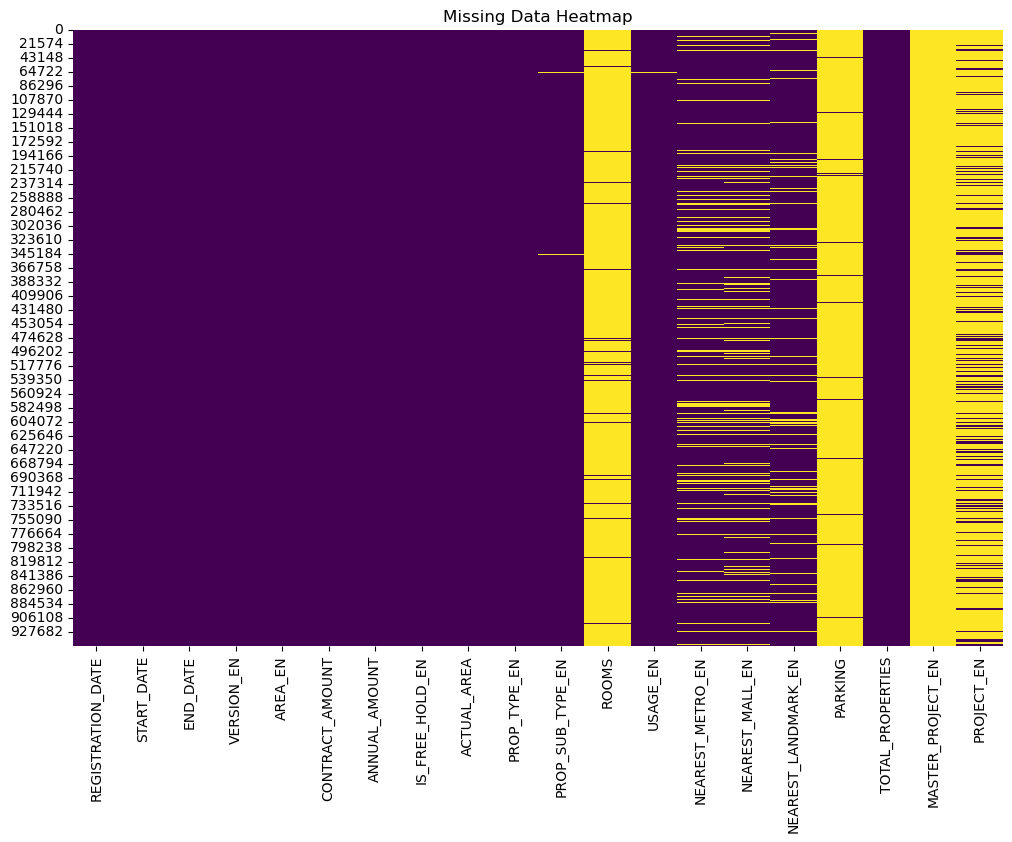

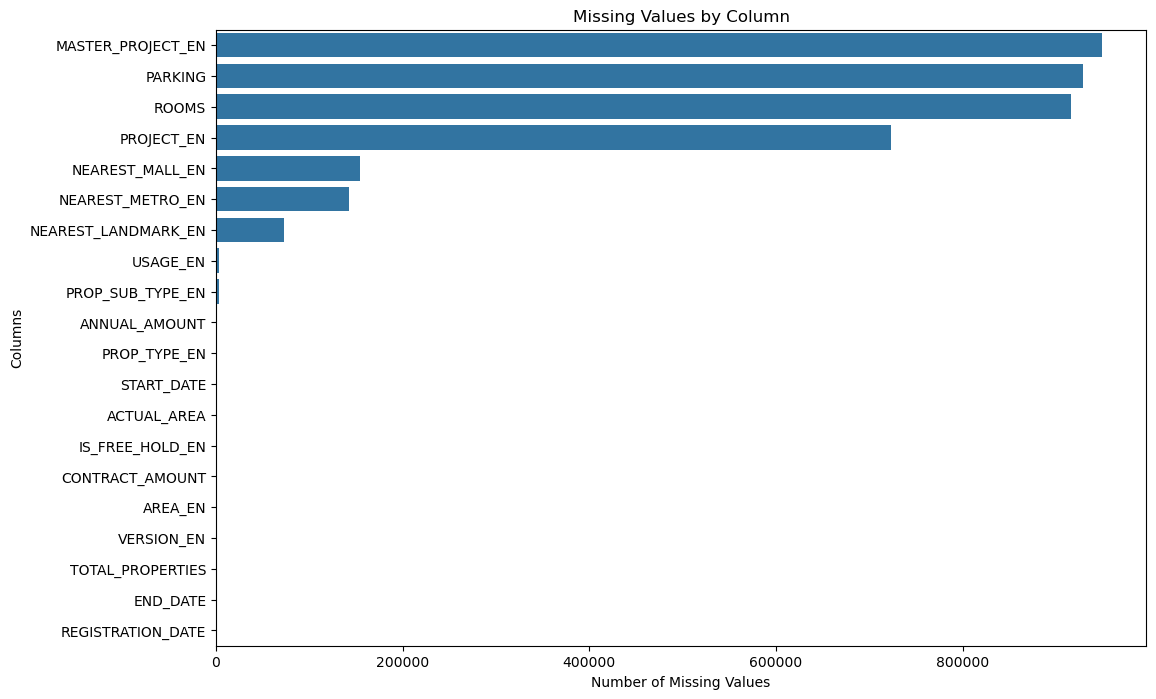

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Visualize missing data using a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(rent_df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Data Heatmap')
plt.show()

# Visualize missing data with a bar plot
missing_values = rent_df.isnull().sum().sort_values(ascending=False)
plt.figure(figsize=(12, 8))
sns.barplot(x=missing_values.values, y=missing_values.index)
plt.title('Missing Values by Column')
plt.xlabel('Number of Missing Values')
plt.ylabel('Columns')
plt.show()


In [91]:
print("\nValuations DataFrame Info:")
valuations_df.info()
print("\nMissing Values in Valuations DataFrame:")
print(valuations_df.isnull().sum())
categorical_columns = valuations_df.select_dtypes(include=['object']).columns.tolist()
print("\nCategorical Columns in Valuations DataFrame:")
print(categorical_columns)

for column in categorical_columns:
    unique_values = valuations_df[column].unique()
    print(f"\nUnique values in '{column}' ({len(unique_values)}):")
    print(unique_values)

print("\nMissing Values in Valuations DataFrame:")
print(valuations_df.isnull().sum())
valuations_df.describe()


Valuations DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6525 entries, 0 to 6524
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   PROPERTY_TOTAL_VALUE  6525 non-null   int64  
 1   AREA_EN               6525 non-null   object 
 2   ACTUAL_AREA           6525 non-null   float64
 3   PROCEDURE_YEAR        6525 non-null   int64  
 4   PROCEDURE_NUMBER      6525 non-null   int64  
 5   INSTANCE_DATE         6525 non-null   object 
 6   ACTUAL_WORTH          6525 non-null   float64
 7   PROCEDURE_AREA        6525 non-null   float64
 8   PROPERTY_TYPE_EN      6525 non-null   object 
 9   PROP_SUB_TYPE_EN      6072 non-null   object 
dtypes: float64(3), int64(3), object(4)
memory usage: 509.9+ KB

Missing Values in Valuations DataFrame:
PROPERTY_TOTAL_VALUE      0
AREA_EN                   0
ACTUAL_AREA               0
PROCEDURE_YEAR            0
PROCEDURE_NUMBER          0
INSTANCE

,PROPERTY_TOTAL_VALUE,ACTUAL_AREA,PROCEDURE_YEAR,PROCEDURE_NUMBER,ACTUAL_WORTH,PROCEDURE_AREA
count,6.525000e+03,6.525000e+03,6525.0,6525.000000,6.525000e+03,6.525000e+03
mean,3.235953e+07,1.231658e+04,2024.0,3919.857471,3.448478e+07,1.419120e+04
std,1.506068e+08,3.907913e+05,0.0,2278.878978,2.257280e+08,4.208790e+05
min,0.000000e+00,1.672000e+01,2024.0,2.000000,1.000000e+00,1.672000e+01
25%,1.957868e+06,1.401400e+02,2024.0,1928.000000,2.000000e+06,1.400000e+02
50%,4.000000e+06,5.547700e+02,2024.0,3930.000000,4.000000e+06,5.559300e+02
75%,1.700000e+07,2.304860e+03,2024.0,5894.000000,1.703260e+07,2.304860e+03
max,4.700000e+09,3.098354e+07,2024.0,7932.000000,1.361443e+10,3.098354e+07


In [92]:
# Summary statistics for categorical columns
categorical_cols = ['AREA_EN', 'INSTANCE_DATE', 'PROPERTY_TYPE_EN', 'PROP_SUB_TYPE_EN']
print("\nSummary Statistics for Categorical Columns:")
print(valuations_df[categorical_cols].describe())



Summary Statistics for Categorical Columns:
            AREA_EN        INSTANCE_DATE PROPERTY_TYPE_EN PROP_SUB_TYPE_EN
count          6525                 6525             6525             6072
unique          192                 6489                3               50
top     Marsa Dubai  2024-10-10 11:14:23             Land             Flat
freq            431                    5             3789             1720


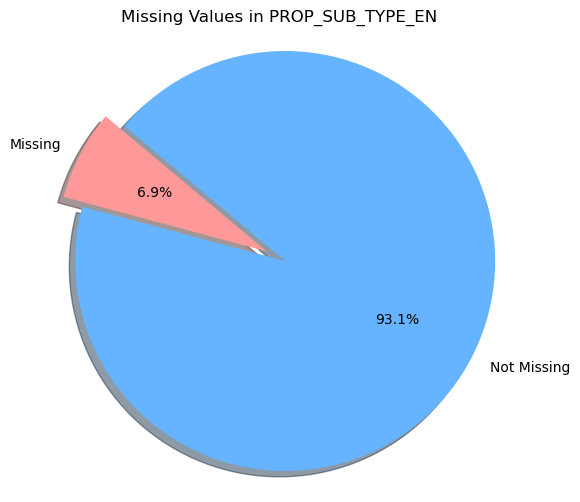

In [93]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate missing values
missing_count = valuations_df['PROP_SUB_TYPE_EN'].isnull().sum()
total = len(valuations_df)
missing_percentage = (missing_count / total) * 100

# Plotting
labels = ['Missing', 'Not Missing']
sizes = [missing_percentage, 100 - missing_percentage]
colors = ['#ff9999','#66b3ff']
explode = (0.1, 0)  # explode first slice

plt.figure(figsize=(6,6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('Missing Values in PROP_SUB_TYPE_EN')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()


In [94]:
# Calculate the mode of PROP_SUB_TYPE_EN for each PROPERTY_TYPE_EN
mode_sub_type = valuations_df.groupby('PROPERTY_TYPE_EN')['PROP_SUB_TYPE_EN'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else 'Unknown Land')

# Function to impute missing PROP_SUB_TYPE_EN based on PROPERTY_TYPE_EN
def impute_sub_type_based_on_property_type(row):
    if row['PROPERTY_TYPE_EN'] == 'Land' and pd.isnull(row['PROP_SUB_TYPE_EN']):
        return mode_sub_type.get(row['PROPERTY_TYPE_EN'], 'Unknown Land')
    else:
        return row['PROP_SUB_TYPE_EN']

# Apply the function
valuations_df['PROP_SUB_TYPE_EN'] = valuations_df.apply(impute_sub_type_based_on_property_type, axis=1)

# Verify the imputation
print("\nMissing Values After Property Type-Based Imputation:")
print(valuations_df['PROP_SUB_TYPE_EN'].isnull().sum())



Missing Values After Property Type-Based Imputation:
0


In [95]:
print("\nProjects DataFrame Info:")
projects_df.info()
print("\nMissing Values in Projects DataFrame:")
print(projects_df.isnull().sum())
categorical_columns = projects_df.select_dtypes(include=['object']).columns.tolist()
print("\nCategorical Columns in Projects DataFrame:")
print(categorical_columns)

for column in categorical_columns:
    unique_values = projects_df[column].unique()
    print(f"\nUnique values in '{column}' ({len(unique_values)}):")
    print(unique_values)

print("\nMissing Values in Projects DataFrame:")
print(projects_df.isnull().sum())
projects_df.describe()


Projects DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 407 entries, 0 to 406
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   PROJECT_NUMBER         407 non-null    int64  
 1   PROJECT_EN             407 non-null    object 
 2   DEVELOPER_NUMBER       407 non-null    int64  
 3   DEVELOPER_EN           407 non-null    object 
 4   START_DATE             407 non-null    object 
 5   END_DATE               257 non-null    object 
 6   ADOPTION_DATE          344 non-null    object 
 7   PRJ_TYPE_EN            407 non-null    object 
 8   PROJECT_VALUE          407 non-null    float64
 9   ESCROW_ACCOUNT_NUMBER  356 non-null    float64
 10  PROJECT_STATUS         407 non-null    object 
 11  PERCENT_COMPLETED      380 non-null    float64
 12  INSPECTION_DATE        380 non-null    object 
 13  COMPLETION_DATE        113 non-null    object 
 14  DESCRIPTION_EN         407 non-n

,PROJECT_NUMBER,DEVELOPER_NUMBER,PROJECT_VALUE,ESCROW_ACCOUNT_NUMBER,PERCENT_COMPLETED,CNT_LAND,CNT_BUILDING,CNT_VILLA,CNT_UNIT
count,407.000000,407.000000,4.070000e+02,3.560000e+02,380.000000,407.000000,407.0,407.000000,407.000000
mean,3049.953317,1413.063882,2.163377e+08,5.782888e+14,3.245752,0.167076,0.0,34.882064,286.297297
std,229.618017,376.187422,2.974252e+08,1.470243e+15,11.822390,1.804919,0.0,118.101279,445.803727
min,982.000000,15.000000,4.000000e+05,2.791370e+05,0.000000,0.000000,0.0,0.000000,0.000000
25%,2943.500000,1124.000000,4.702321e+07,1.900008e+10,0.000000,0.000000,0.0,0.000000,53.000000
50%,3058.000000,1456.000000,1.000000e+08,2.058814e+11,0.000000,0.000000,0.0,0.000000,156.000000
75%,3194.000000,1746.000000,2.751795e+08,1.262128e+13,0.025000,0.000000,0.0,0.000000,307.500000
max,3424.000000,2124.000000,2.204684e+09,9.419226e+15,146.395700,36.000000,0.0,758.000000,3438.000000


C:\Users\Roadslink\AppData\Local\Temp\ipykernel_28104\3812796376.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=missing_counts.values, y=missing_counts.index, palette='magma')


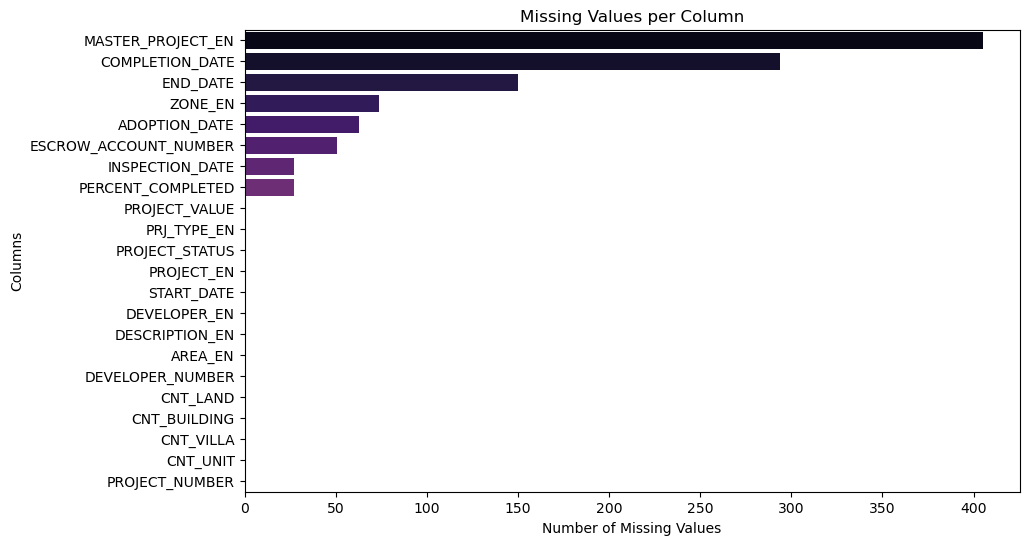

In [96]:
# Calculate missing values per column
missing_counts = projects_df.isnull().sum()

# Sort the missing counts in descending order
missing_counts = missing_counts.sort_values(ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=missing_counts.values, y=missing_counts.index, palette='magma')
plt.title('Missing Values per Column')
plt.xlabel('Number of Missing Values')
plt.ylabel('Columns')
plt.show()


In [ ]:
# projects_df.drop('MASTER_PROJECT_EN', axis=1, inplace=True)
# Ensure START_DATE and COMPLETION_DATE are datetime
projects_df['START_DATE'] = pd.to_datetime(projects_df['START_DATE'], errors='coerce')
projects_df['COMPLETION_DATE'] = pd.to_datetime(projects_df['COMPLETION_DATE'], errors='coerce')

# Calculate duration for projects with COMPLETION_DATE
completed_projects = projects_df.dropna(subset=['COMPLETION_DATE'])
completed_projects['DURATION'] = (completed_projects['COMPLETION_DATE'] - completed_projects['START_DATE']).dt.days
median_duration = completed_projects['DURATION'].median()

# Impute COMPLETION_DATE for active projects
projects_df['COMPLETION_DATE'] = projects_df.apply(
    lambda row: row['START_DATE'] + pd.Timedelta(days=median_duration) 
    if pd.isnull(row['COMPLETION_DATE']) and row['PROJECT_STATUS'] == 'ACTIVE' 
    else row['COMPLETION_DATE'], axis=1
)


C:\Users\Roadslink\AppData\Local\Temp\ipykernel_28104\1500362323.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  completed_projects['DURATION'] = (completed_projects['COMPLETION_DATE'] - completed_projects['START_DATE']).dt.days


In [77]:
# Ensure START_DATE and END_DATE are datetime
projects_df['START_DATE'] = pd.to_datetime(projects_df['START_DATE'], errors='coerce')
projects_df['END_DATE'] = pd.to_datetime(projects_df['END_DATE'], errors='coerce')

# Calculate duration for projects with END_DATE
projects_df['DURATION'] = (projects_df['END_DATE'] - projects_df['START_DATE']).dt.days

# Calculate median duration
median_duration = projects_df['DURATION'].median()

# Impute END_DATE for missing values
projects_df['END_DATE'] = projects_df.apply(
    lambda row: row['START_DATE'] + pd.Timedelta(days=median_duration) 
    if pd.isnull(row['END_DATE']) else row['END_DATE'], axis=1
)


In [78]:
mode_zone = projects_df['ZONE_EN'].mode()[0]
projects_df['ZONE_EN'].fillna(mode_zone, inplace=True)
# Convert to datetime if not already
projects_df['ADOPTION_DATE'] = pd.to_datetime(projects_df['ADOPTION_DATE'], errors='coerce')

# Impute with median
median_adoption = projects_df['ADOPTION_DATE'].median()
projects_df['ADOPTION_DATE'].fillna(median_adoption, inplace=True)

C:\Users\Roadslink\AppData\Local\Temp\ipykernel_28104\2365517147.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  projects_df['ZONE_EN'].fillna(mode_zone, inplace=True)
C:\Users\Roadslink\AppData\Local\Temp\ipykernel_28104\2365517147.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a 

In [79]:
# Convert categorical columns to lowercase and strip whitespace
categorical_cols = ['DEVELOPER_EN', 'PROJECT_STATUS', 'AREA_EN', 'ZONE_EN', 'PRJ_TYPE_EN']

for col in categorical_cols:
    projects_df[col] = projects_df[col].astype(str).str.lower().str.strip()


In [81]:
numerical_cols = ['PROJECT_VALUE', 'PERCENT_COMPLETED', 'CNT_LAND', 
                  'CNT_BUILDING', 'CNT_VILLA', 'CNT_UNIT']

projects_df[numerical_cols] = projects_df[numerical_cols].apply(pd.to_numeric, errors='coerce')


In [82]:
# Convert all date columns to datetime
date_cols = ['START_DATE', 'END_DATE', 'ADOPTION_DATE', 'INSPECTION_DATE', 'COMPLETION_DATE']
for col in date_cols:
    projects_df[col] = pd.to_datetime(projects_df[col], errors='coerce')


In [83]:
from sklearn.impute import KNNImputer

# Initialize KNN Imputer
knn_imputer = KNNImputer(n_neighbors=5)

# Apply KNN Imputer to numerical columns
projects_df[numerical_cols] = knn_imputer.fit_transform(projects_df[numerical_cols])


In [85]:
# Mode Imputation
mode_escrow = projects_df['ESCROW_ACCOUNT_NUMBER'].mode()[0]
projects_df['ESCROW_ACCOUNT_NUMBER'].fillna(mode_escrow, inplace=True)


C:\Users\Roadslink\AppData\Local\Temp\ipykernel_28104\1202997227.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  projects_df['ESCROW_ACCOUNT_NUMBER'].fillna(mode_escrow, inplace=True)


In [16]:
print("\nLands DataFrame Info:")
lands_df.info()
print("\nMissing Values in Lands DataFrame:")
print(lands_df.isnull().sum())
categorical_columns = lands_df.select_dtypes(include=['object']).columns.tolist()
print("\nCategorical Columns in Lands DataFrame:")
print(categorical_columns)

for column in categorical_columns:
    unique_values = lands_df[column].unique()
    print(f"\nUnique values in '{column}' ({len(unique_values)}):")
    print(unique_values)

print("\nMissing Values in Lands DataFrame:")
print(lands_df.isnull().sum())
lands_df.describe()


Lands DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211087 entries, 0 to 211086
Data columns (total 12 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   LAND_TYPE_EN             197003 non-null  object 
 1   PROP_SUB_TYPE_EN         182250 non-null  object 
 2   ACTUAL_AREA              209478 non-null  float64
 3   IS_OFFPLAN_EN            211087 non-null  object 
 4   PRE_REGISTRATION_NUMBER  103045 non-null  object 
 5   IS_FREE_HOLD_EN          211087 non-null  object 
 6   DM_ZIP_CODE              211087 non-null  int64  
 7   MASTER_PROJECT_EN        9 non-null       object 
 8   PROJECT_NUMBER           68043 non-null   float64
 9   PROJECT_EN               68043 non-null   object 
 10  AREA_EN                  211087 non-null  object 
 11  ZONE_EN                  211087 non-null  object 
dtypes: float64(2), int64(1), object(9)
memory usage: 19.3+ MB

Missing Values in Lands DataFram

,ACTUAL_AREA,DM_ZIP_CODE,PROJECT_NUMBER
count,2.094780e+05,211087.000000,68043.000000
mean,3.396234e+04,518.444466,2098.271725
std,5.983984e+06,221.826630,678.071432
min,0.000000e+00,0.000000,-2180.000000
25%,3.344500e+02,347.000000,1595.000000
50%,8.160000e+02,531.000000,2221.000000
75%,1.393550e+03,676.000000,2559.500000
max,2.632733e+09,991.000000,3426.000000


In [17]:
print("\nDevelopers DataFrame Info:")
developers_df.info()
print("\nMissing Values in Developers DataFrame:")
print(developers_df.isnull().sum())
categorical_columns = developers_df.select_dtypes(include=['object']).columns.tolist()
print("\nCategorical Columns in Developers DataFrame:")
print(categorical_columns)

for column in categorical_columns:
    unique_values = developers_df[column].unique()
    print(f"\nUnique values in '{column}' ({len(unique_values)}):")
    print(unique_values)

print("\nMissing Values in Developers DataFrame:")
print(developers_df.isnull().sum())
developers_df.describe()


Developers DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 330 entries, 0 to 329
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   DEVELOPER_NUMBER        330 non-null    int64  
 1   DEVELOPER_EN            330 non-null    object 
 2   REGISTRATION_DATE       330 non-null    object 
 3   LICENSE_SOURCE_EN       330 non-null    object 
 4   LICENSE_TYPE_EN         273 non-null    object 
 5   LEGAL_STATUS_EN         3 non-null      object 
 6   WEBPAGE                 10 non-null     object 
 7   PHONE                   118 non-null    object 
 8   FAX                     84 non-null     object 
 9   LICENSE_NUMBER          330 non-null    object 
 10  LICENSE_ISSUE_DATE      330 non-null    object 
 11  LICENSE_EXPIRY_DATE     330 non-null    object 
 12  CHAMBER_OF_COMMERCE_NO  0 non-null      float64
dtypes: float64(1), int64(1), object(11)
memory usage: 33.6+ KB

Missing

,DEVELOPER_NUMBER,CHAMBER_OF_COMMERCE_NO
count,330.000000,0.0
mean,1984.500000,NaN
std,95.407023,NaN
min,1820.000000,NaN
25%,1902.250000,NaN
50%,1984.500000,NaN
75%,2066.750000,NaN
max,2149.000000,NaN


In [18]:
print("\nBrokers DataFrame Info:")
brokers_df.info()
print("\nMissing Values in Brokers DataFrame:")
print(brokers_df.isnull().sum())
categorical_columns = brokers_df.select_dtypes(include=['object']).columns.tolist()
print("\nCategorical Columns in Brokers DataFrame:")
print(categorical_columns)

for column in categorical_columns:
    unique_values = brokers_df[column].unique()
    print(f"\nUnique values in '{column}' ({len(unique_values)}):")
    print(unique_values)
    
print("\nMissing Values in Brokers DataFrame:")
print(brokers_df.isnull().sum())
brokers_df.describe()


Brokers DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28968 entries, 0 to 28967
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   BROKER_NUMBER       28968 non-null  int64 
 1   BROKER_EN           28967 non-null  object
 2   GENDER_EN           28968 non-null  object
 3   LICENSE_START_DATE  28964 non-null  object
 4   LICENSE_END_DATE    28964 non-null  object
 5   WEBPAGE             5 non-null      object
 6   PHONE               24467 non-null  object
 7   FAX                 4202 non-null   object
 8   REAL_ESTATE_NUMBER  28968 non-null  int64 
 9   REAL_ESTATE_EN      28968 non-null  object
dtypes: int64(2), object(8)
memory usage: 2.2+ MB

Missing Values in Brokers DataFrame:
BROKER_NUMBER             0
BROKER_EN                 1
GENDER_EN                 0
LICENSE_START_DATE        4
LICENSE_END_DATE          4
WEBPAGE               28963
PHONE                  4501
FAX   

,BROKER_NUMBER,REAL_ESTATE_NUMBER
count,28968.000000,28968.000000
mean,57426.202085,23753.338477
std,15289.857863,13224.719178
min,10.000000,3.000000
25%,49065.250000,12734.750000
50%,60807.000000,26250.000000
75%,69351.500000,33912.750000
max,99999.000000,46958.000000


In [4]:
# Total properties in the market
total_properties = lands_df.shape[0]
total_properties

211087

In [7]:
# Convert INSTANCE_DATE to datetime
transactions_df['INSTANCE_DATE'] = pd.to_datetime(transactions_df['INSTANCE_DATE'])

# Define the period (e.g., last 1 year)
start_date = pd.to_datetime('2024-01-01')
end_date = pd.to_datetime('2024-12-31')

# Filter transactions in the period
sales_in_period = transactions_df[
    (transactions_df['INSTANCE_DATE'] >= start_date) &
    (transactions_df['INSTANCE_DATE'] <= end_date) &
    (transactions_df['PROCEDURE_EN'] == 'Sale')
]
number_of_sales = sales_in_period.shape[0]

sales_supply_index = number_of_sales / total_properties
print(f"Sales Supply Index: {sales_supply_index:.4f}")


Sales Supply Index: 0.2101


In [8]:
# Sales Supply Index at Unit Level
unit_sales_supply_index = sales_in_period.groupby('PROP_TYPE_EN').size() / total_properties
print(unit_sales_supply_index)


PROP_TYPE_EN
Building    0.013118
Land        0.030641
Unit        0.166367
dtype: float64
